# Image Feature Extraction

**Image feature extraction** is the task of extracting semantically meaningful features given an image.

## Image similarity using image-feature-extraction pipeline

In [18]:
# load images
from PIL import Image
import requests

img_urls = [
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png",
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.jpeg"
]

image_real = Image.open(requests.get(img_urls[0], stream=True).raw)
image_real = image_real.convert('RGB')
image_fake = Image.open(requests.get(img_urls[1], stream=True).raw)
image_fake = image_fake.convert('RGB')

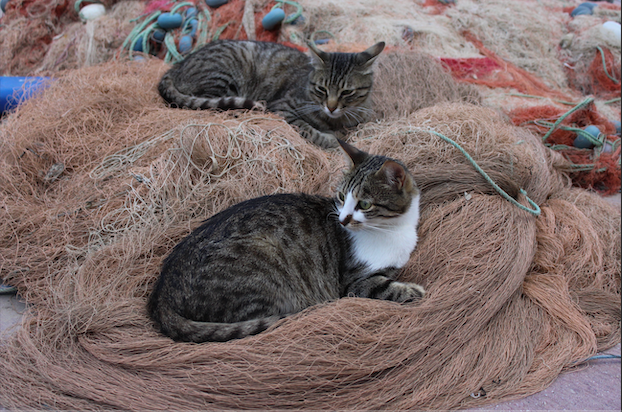

In [2]:
image_real

In [3]:
image_fake

Output hidden; open in https://colab.research.google.com to view.

In [4]:
# Load ViT
import torch
from transformers import pipeline
from accelerate.test_utils.testing import get_backend

device, _, _ = get_backend()
pipe = pipeline(
    task='image-feature-extraction',
    model_name='google/vit-base-patch16-384',
    device=device,
    pool=True
)

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cpu


In [5]:
outputs = pipe([image_real, image_fake])

In [6]:
# get the length of a single output
print(len(outputs[0][0]))
# show outputs
print(outputs)

768
[[[-0.3238513469696045, -0.3022722005844116, 0.23147957026958466, 0.2462802529335022, -0.2864139676094055, 0.7112938761711121, -0.439662903547287, 0.44945472478866577, 0.568782389163971, 0.08546843379735947, -0.11491145938634872, 0.5981460213661194, 0.2540965676307678, -0.43158915638923645, 0.24403467774391174, 0.1756286770105362, -0.1317588984966278, 0.04653520509600639, 0.08732257038354874, 0.129445418715477, -0.3625369369983673, -0.7249739766120911, -0.11057809740304947, 0.23301823437213898, -0.6858368515968323, -0.5048074722290039, 0.18699735403060913, -0.6967607140541077, 0.08915042877197266, 0.6118963360786438, 0.4342244267463684, -0.516291081905365, 0.4717887043952942, 0.2055564969778061, -0.20513437688350677, -0.737683117389679, -0.19638313353061676, 0.3803059458732605, 0.2389187514781952, -0.6220876574516296, 0.24820438027381897, 0.2597125768661499, -0.12722046673297882, 0.38860952854156494, -0.6684431433677673, -0.03765726834535599, -0.2427159547805786, -0.133994653820991

Get the similarity score:

In [7]:
from torch.nn.functional import cosine_similarity

similarity_score = cosine_similarity(
    torch.Tensor(outputs[0]),
    torch.Tensor(outputs[1]),
    dim=1
)
similarity_score

tensor([0.5334])

If we want to get the last hidden states before pooling, we can avoid passing any value for the `pool` paramter, as it is set to `False` by default. These hidden states are useful for training new classifiers or models based on the features from the model.

In [ ]:
pipe = pipeline(
    task='image-feature-extraction',
    model_name='google/vit-base-patch16-384',
    device=device,
    pool=False
)

In [10]:
outputs = pipe(image_real)

Since the outputs are unpooled, we get the last hidden states where the first dimension is the batch size, and the last two are the embedding shape:

In [11]:
import numpy as np
np.array(outputs).shape

(1, 197, 768)

## Gettting features and similarities using `AutoModel`

In [ ]:
from transformers import AutoImageProcessor, AutoModel

processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-384')
model = AutoModel.from_pretrained('google/vit-base-patch16-384').to(device)

In [16]:
def infer(image):
    inputs = processor(image, return_tensors='pt').to(device)
    outputs = model(**inputs)
    return outputs.pooler_output

In [19]:
embed_real = infer(image_real)
embed_fake = infer(image_fake)

After we get the embeddings, we can get the similarity score again over the embeddings:

In [20]:
from torch.nn.functional import cosine_similarity

similarity_score = cosine_similarity(
    embed_real,
    embed_fake,
    dim=1
)
similarity_score

tensor([0.6379], grad_fn=<SumBackward1>)